Dataset preprocessing (early) 5.30.24

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr
import h5py
import sys

sys.path.append('../../')

from tqdm.notebook import tqdm
from data.data_utils import *

In [2]:
# Load extracted S1 polygons
data_root = '/u/ayang1/foundm/scratch_sc/data'

portugal = pd.read_csv(
    os.path.join(
        data_root,
        's1_lucas/raw_csvs/S1_point_10days_10m_1Jan-31Dec_Portugal_ratio-db.csv'
        )
    )

In [3]:
# Load filtered LUCAS_2018 dataset
lucas_2018_filtered = pd.read_csv(os.path.join(data_root, 'lucas/lucas_2018/lucas_2018_filtered.csv'))

/tmp/ipykernel_18582/3355018004.py:2: DtypeWarning: Columns (34,39,44) have mixed types. Specify dtype option on import or set low_memory=False.
  lucas_2018_filtered = pd.read_csv(os.path.join(data_root, 'lucas/lucas_2018/lucas_2018_filtered.csv'))


In [4]:
labeled = add_lucas_labels(portugal, lucas_2018_filtered)
labeled.drop('system:index', axis=1, inplace=True)
labeled = labeled.loc[labeled['LABEL']!='NOT_CROP']

Loading files
Creating dataset of size 64780


100%|██████████| 64780/64780 [00:27<00:00, 2330.81it/s]


In [22]:
vhvv = labeled.loc[:, labeled.columns[1:37]].to_numpy()
vh = labeled.loc[:, labeled.columns[37:73]].to_numpy()
vv = labeled.loc[:, labeled.columns[73:109]].to_numpy()
point_ids = labeled['POINT_ID'].to_numpy()
labels = labeled['LABEL'].to_numpy()
dates = np.array([x.split('_')[1] for x in labeled.columns[1:37]]).astype(object)

In [23]:
dates

array(['20180101', '20180111', '20180121', '20180131', '20180210',
       '20180220', '20180302', '20180312', '20180322', '20180401',
       '20180411', '20180421', '20180501', '20180511', '20180521',
       '20180531', '20180610', '20180620', '20180630', '20180710',
       '20180720', '20180730', '20180809', '20180819', '20180829',
       '20180908', '20180918', '20180928', '20181008', '20181018',
       '20181028', '20181107', '20181117', '20181127', '20181207',
       '20181217'], dtype=object)

In [24]:
with h5py.File('test.h5', 'w') as f:
    # Create a dataset in the file
        length = len(labels)
        f.create_dataset('vhvv', (length, 36), data=vhvv)
        f.create_dataset('vh', (length, 36), data=vh)
        f.create_dataset('vv', (length, 36), data=vv)
        f.create_dataset('point_id', (length), data=point_ids)
        f.create_dataset('label', (length), data=labels)
        f.create_dataset('date', (36), data=dates)

In [31]:
with h5py.File('test.h5', 'w') as f:
    print([key for key in f.keys()])

[]


In [25]:
arr = load_data('test.h5')

### Dataset inspection

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import os
import numpy as np

data_root = '../scratch_sc/data/'

sns.set_theme()

In [2]:
data_processed = pd.read_csv(os.path.join(data_root, 's1_lucas/mini_dataset/NE1a_data.csv'), index_col=0)


FileNotFoundError: [Errno 2] No such file or directory: '../scratch_sc/data/s1_lucas/mini_dataset/NE1a_data.csv'

In [9]:
data_processed.head()

NameError: name 'data_processed' is not defined

In [39]:
crop_data = data_processed[data_processed['LABEL'].str.contains('B')]
crop_data.loc[:, 'LABEL'] = crop_data['LABEL'].apply(lambda x: x[9:12])

In [45]:
crop_data['LABEL'].value_counts()

LABEL
B11    19029
B13     7266
B32     6208
B16     4919
B14     2961
B22     1857
B52     1749
B18     1639
B55     1535
B15     1403
B51      949
B41      805
B33      775
B12      757
B21      644
B53      637
B19      496
B31      430
B35      256
B71      114
B84       75
B54       66
B37       65
B74       44
B23       35
B36       15
B83        9
Name: count, dtype: int64

In [9]:
hdf_path = os.path.join(data_root, 's1_lucas/mini_dataset/data_mini.hdf')
with h5py.File(hdf_path, 'w') as f:
    length = len(data_processed)
    print(length)
    vhvv = f.create_dataset('vhvv', (length, 36), data=data_processed.loc[:, data_processed.columns[1:37]].to_numpy())
    vh = f.create_dataset('vh', (length, 36), data=data_processed.loc[:, data_processed.columns[37:73]].to_numpy())
    vv = f.create_dataset('vv', (length, 36), data=data_processed.loc[:, data_processed.columns[73:109]].to_numpy())
    labels = f.create_dataset('labels', (length, 1), data=data_processed['LABEL'].to_numpy())



2508


In [3]:
oat = data_processed.loc[data_processed['LABEL']=='B15']
vhvv = oat.loc[:, oat.columns[1:37]]
vh = oat.loc[:, oat.columns[37:73]]
vv = oat.loc[:, oat.columns[73:109]]

vhvv_u = vhvv.mean(axis=0)
vh_u = vh.mean(axis=0)
vv_u = vv.mean(axis=0)

vhvv_s = vhvv.std(axis=0)
vh_s = vh.std(axis=0)
vv_s = vv.std(axis=0)

In [4]:
def to_long(df):
    df_t = df.transpose()
    df_t.index.name = 'time'
    df_t['time'] = df_t.index
    df_long = df_t.melt(id_vars='time', var_name='sample', value_name='value')
    df_long['time'] = [x.split('_')[1] for x in df_long['time']]
    
    return df_long

/u/ayang1/.conda/envs/data/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/u/ayang1/.conda/envs/data/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/u/ayang1/.conda/envs/data/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/u/ayang1/.conda/envs/data/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future

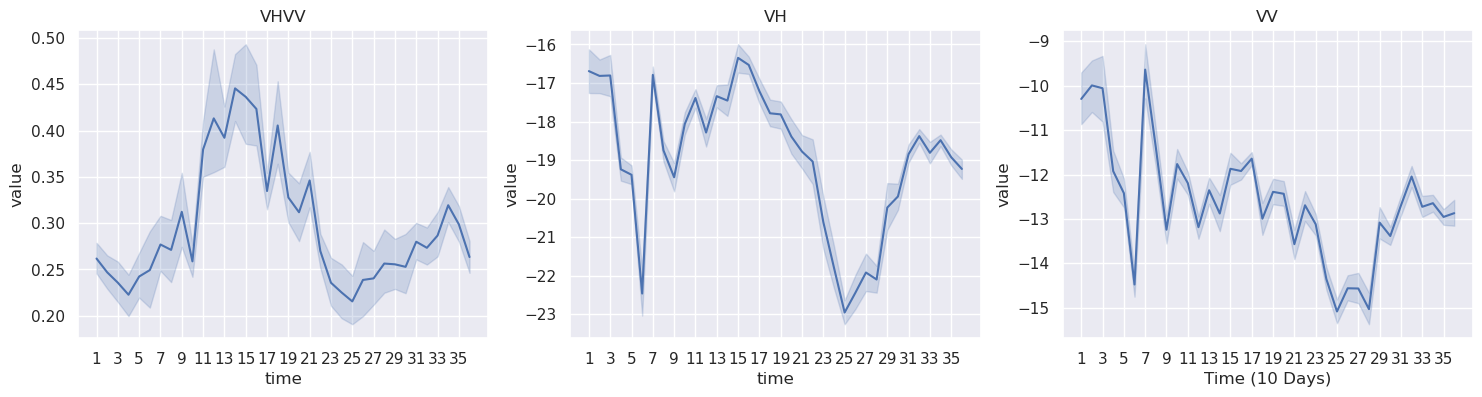

In [8]:
oat_vhvv = to_long(vhvv)
oat_vh = to_long(vh)
oat_vv = to_long(vv)

# Plot the mean line with standard deviation
fig, axs = plt.subplots(1, 3, figsize=(18,4), sharex=True)

sns.lineplot(x='time', y='value', data=oat_vhvv, ax=axs[0])
sns.lineplot(x='time', y='value', data=oat_vh, ax=axs[1])
sns.lineplot(x='time', y='value', data=oat_vv, ax=axs[2])

plt.xlabel('Time (10 Days)')
axs[0].set_title('VHVV')
axs[1].set_title('VH')
axs[2].set_title('VV')
plt.xticks(oat_vhvv['time'].unique()[::2], np.arange(1, 37, step=2))
plt.show()

In [9]:
oat_vh

,time,sample,value
0,20180101,291,-16.244530
1,20180111,291,-14.058039
2,20180121,291,-13.884295
3,20180131,291,-17.479908
4,20180210,291,-18.228758
...,...,...,...
2839,20181107,2173,-18.619362
2840,20181117,2173,-17.797997
2841,20181127,2173,-18.219778
2842,20181207,2173,-17.979542


### Dataloader inspection

In [1]:
import os
import sys
import xarray as xr
import torch
import numpy as np

sys.path.append('../')
from data.data_utils import *
from data.dataset import *
from torch.utils.data import Dataset

torch.manual_seed(0)

In [6]:
data_root = '../../scratch_sc/data/'
country = 'portugal'

with xr.open_dataset(os.path.join(data_root, f's1_lucas/datasets/{country}_s1.h5')) as ds:
    labels = np.unique(ds.label)
    keys = encode_labels(labels)
    
ds = CropTypeDataset(os.path.join(data_root, f's1_lucas/datasets/{country}_s1.h5'), keys=keys)

In [7]:
print(len(ds))

3659


In [9]:
idx = torch.randint(0, len(ds), (1,1)).item()
signals, label = ds[idx] # VHVV, VH, VV, label

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


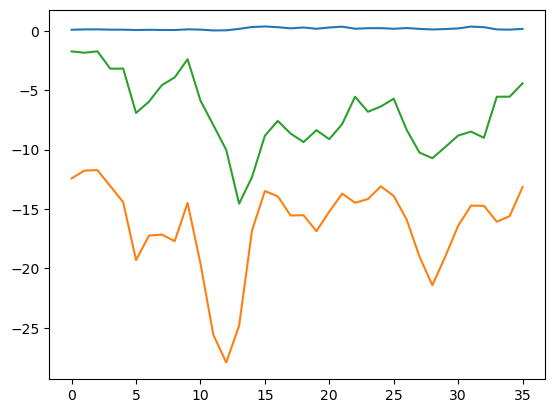

In [11]:
plt.plot(signals[0], label='VHVV')
plt.plot(signals[1], label='VH')
plt.plot(signals[2], label='VV')
print(label)

### Combine datasets

In [1]:
import xarray as xr
import os

In [2]:
data_root = '/u/ayang1/foundm/scratch_sc/data/s1_lucas/datasets'
data = []

for ds in os.listdir(data_root):
    with xr.open_dataset(os.path.join(data_root, ds)) as ds:
        data.append(ds)


In [27]:
combined = xr.merge(data, compat='identical')

ValueError: cannot reindex or align along dimension 'point_id' because the (pandas) index has duplicate values

In [7]:
combined = ds.to_netcdf(os.path.join('/u/ayang1/foundm/scratch_sc/data/s1_lucas/datasets', 'ir_nd_pt_s1.h5'))


In [29]:
len(combined['point_id'])

11185

In [8]:
import sys
sys.path.append('../../')
from data.dataset import *


In [10]:
ds = CropTypeDataset('/u/ayang1/foundm/scratch_sc/data/s1_lucas/datasets/ir_nd_pt_s1.h5')

In [11]:
len(ds)

3659